# Prerequisite

## Participating the Competition
다음 링크에서 Kaggle Competition에 참가: https://www.kaggle.com/competitions/2024-knu-ml-ind-asmt2/overview

주의: 참가 시 Team - Team Name을 **학번 / 이름**으로 설정

## Data Download

Kaggle 프로필 아이콘 - Settings - API - Create New Token 선택 후 다운로드 된 **kaggle.json**에서, **username**과 **key** 값을 아래에 기록

In [168]:
USERNAME = "liebenholz" # username
USERKEY = "" # key

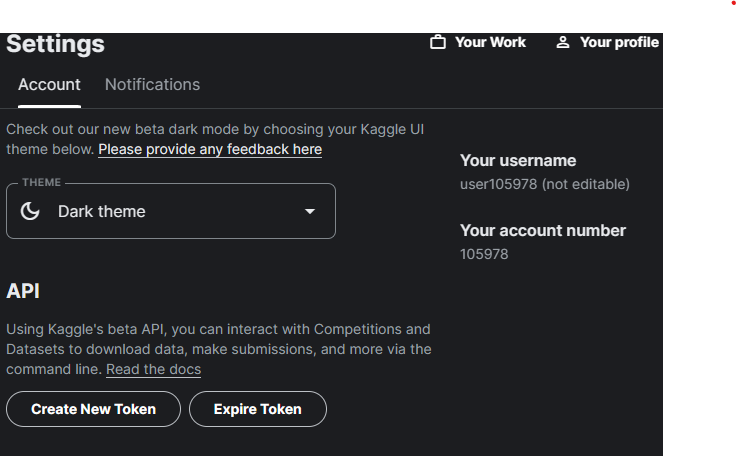

Kaggle 인증 정보 생성


In [169]:
import json


json.dump({'username': USERNAME, 'key': USERKEY}, open('kaggle.json', mode='w'))

만약 Colab이 아닌 로컬 환경에서 하고 싶다면 OS에 따라 인증 정보 설정 방법이 다르므로, [Kaggle API](https://github.com/Kaggle/kaggle-api)를 참조

In [170]:
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download --force 2024-knu-ml-ind-asmt2
!unzip 2024-knu-ml-ind-asmt2.zip

mkdir: cannot create directory ‘/root/.kaggle/’: File exists
  0% 0.00/105k [00:00<?, ?B/s]
100% 105k/105k [00:00<00:00, 50.2MB/s]
Archive:  2024-knu-ml-ind-asmt2.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


## Installing Libraries
* [scikit-learn](https://scikit-learn.org/stable/index.html): 다목적 기계 학습 라이브러리
* [numpy](https://numpy.org/): 배열 유틸리티
* [pandas](https://pandas.pydata.org/): 데이터 활용 유틸리티
* [altair](https://altair-viz.github.io/index.html): 시각화
* [kaggle](https://github.com/Kaggle/kaggle-api): Kaggle API 활용

In [171]:
!pip install -q scikit-learn==1.4.1.post1 numpy pandas altair kaggle==1.6.6 graphviz

# Data Exploration / Preprocessing

다운로드 받은 데이터를 Pandas Dataframe으로 불러옴

In [172]:
import pandas as pd

TRAIN = pd.read_csv('./train.csv', index_col='id')

데이터 예시

In [173]:
TRAIN.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
id,,,,,,,,,,,,
361.0,7.1,0.365,0.14,1.2,0.055,24.0,84.0,0.99410,3.15,0.43,8.9,1.0
1926.0,6.3,0.220,0.57,1.4,0.208,14.0,96.0,0.99320,3.16,0.43,10.0,0.0
1606.0,7.5,0.320,0.49,1.7,0.031,44.0,109.0,0.99060,3.07,0.46,12.5,1.0
1308.0,9.2,0.150,0.68,1.6,0.046,22.0,130.0,0.99480,3.02,0.45,10.4,1.0
767.0,6.8,0.200,0.36,1.6,0.028,7.0,46.0,0.99175,3.21,0.60,10.9,0.0


입력 데이터
* id: 화이트 와인의 ID
* fixed acidity: 타르타르산 농도
* volatile acidity: 아세트산 농도
* citric acid: 구연산 농도
* residual sugar: 잔류 설탕 농도
* chlorides: 염도
* free sulfur dioxide: 유리 이산화황 농도
* total sulfur dioxide: 전체 이산화황 농도
* density: 밀도
* pH: 산성도
* sulphates: 황산칼륨 농도
* alcohol: 알콜농도
    
출력 데이터
* quality: 품질; 1(좋음) vs. 0(나쁨).


데이터 타입

In [174]:
TRAIN.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 2938 entries, 361.0 to 1265.0
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         2938 non-null   float64
 1   volatile acidity      2938 non-null   float64
 2   citric acid           2938 non-null   float64
 3   residual sugar        2938 non-null   float64
 4   chlorides             2938 non-null   float64
 5   free sulfur dioxide   2938 non-null   float64
 6   total sulfur dioxide  2938 non-null   float64
 7   density               2938 non-null   float64
 8   pH                    2938 non-null   float64
 9   sulphates             2938 non-null   float64
 10  alcohol               2938 non-null   float64
 11  quality               2938 non-null   float64
dtypes: float64(12)
memory usage: 298.4 KB


Pandas Dataframe에서 object 데이터 타입은 보통 문자열 등의 범주형Categorical 데이터, int 또는 float는 수치형Numerical 데이터로 이해하면 됨

## Check Missing Data

데이터가 결측치가 없이 제대로 수집되어 있는지 확인

In [175]:
for c in TRAIN.columns:
    print(f'{c}: {len(TRAIN[c].loc[TRAIN[c].isnull()])}')

fixed acidity: 0
volatile acidity: 0
citric acid: 0
residual sugar: 0
chlorides: 0
free sulfur dioxide: 0
total sulfur dioxide: 0
density: 0
pH: 0
sulphates: 0
alcohol: 0
quality: 0


결측치 없으므로 결측치 제거 작업은 생략한다.

## Exploration: Continuous Variable


array([[<Axes: title={'center': 'fixed acidity'}>,
        <Axes: title={'center': 'volatile acidity'}>,
        <Axes: title={'center': 'citric acid'}>],
       [<Axes: title={'center': 'residual sugar'}>,
        <Axes: title={'center': 'chlorides'}>,
        <Axes: title={'center': 'free sulfur dioxide'}>],
       [<Axes: title={'center': 'total sulfur dioxide'}>,
        <Axes: title={'center': 'density'}>,
        <Axes: title={'center': 'pH'}>],
       [<Axes: title={'center': 'sulphates'}>,
        <Axes: title={'center': 'alcohol'}>,
        <Axes: title={'center': 'quality'}>]], dtype=object)

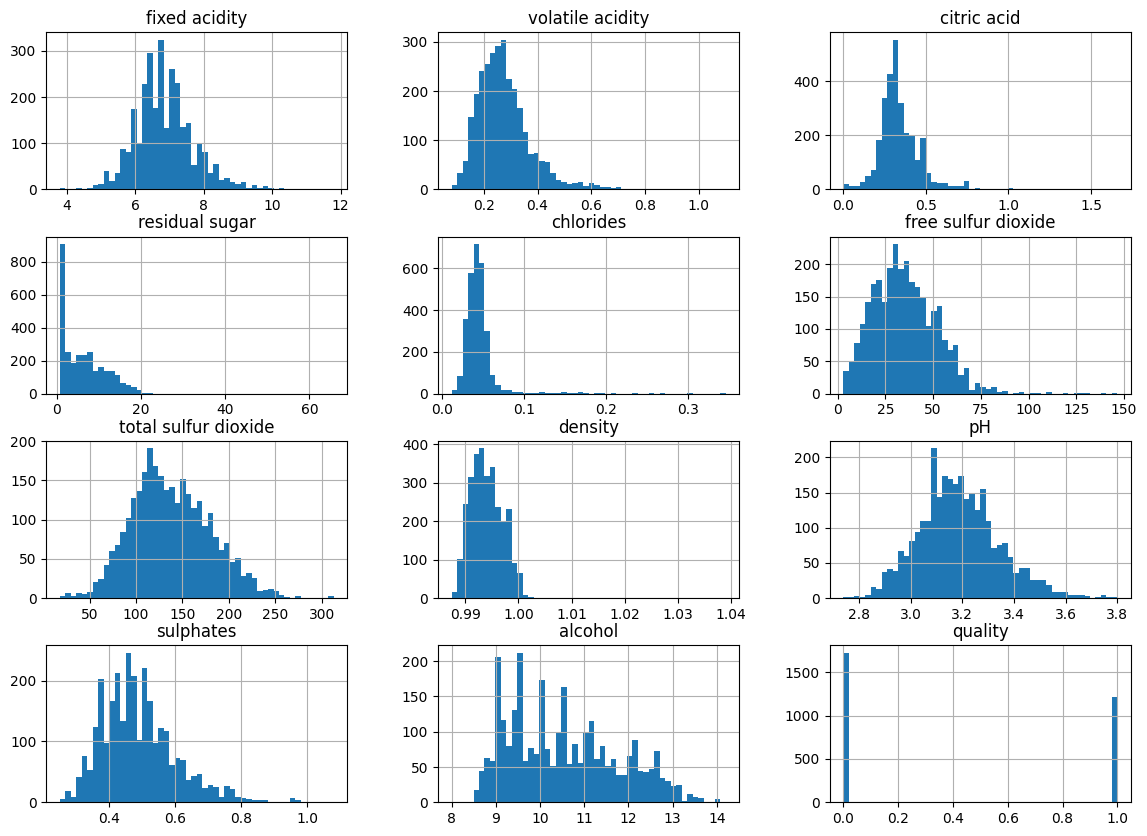

In [176]:
TRAIN.hist(bins = 50, figsize = (14, 10))

In [148]:
TRAIN.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000
mean,6.850085,0.277097,0.338319,6.381552,0.045725,35.371171,137.986045,0.994003,3.186426,0.488907,10.532912,0.412866
std,0.851294,0.099441,0.123497,5.088212,0.021732,16.838929,42.154930,0.003046,0.153306,0.114427,1.235689,0.492433
min,3.800000,0.080000,0.000000,0.700000,0.012000,3.000000,18.000000,0.987420,2.740000,0.250000,8.000000,0.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991700,3.080000,0.410000,9.500000,0.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993700,3.180000,0.470000,10.400000,0.000000
75%,7.300000,0.320000,0.390000,9.887500,0.050000,46.000000,167.000000,0.996000,3.280000,0.550000,11.400000,1.000000
max,11.800000,1.100000,1.660000,65.800000,0.346000,146.500000,313.000000,1.038980,3.800000,1.080000,14.200000,1.000000


### Preprocessing: Log Scaling

극단적인 값들의 영향을 줄이고 분포를 고르게 만드는 방법 중 하나는 로그를 취하는 것

array([[<Axes: title={'center': 'fixed acidity'}>,
        <Axes: title={'center': 'volatile acidity'}>,
        <Axes: title={'center': 'citric acid'}>,
        <Axes: title={'center': 'residual sugar'}>],
       [<Axes: title={'center': 'chlorides'}>,
        <Axes: title={'center': 'free sulfur dioxide'}>,
        <Axes: title={'center': 'total sulfur dioxide'}>,
        <Axes: title={'center': 'density'}>],
       [<Axes: title={'center': 'pH'}>,
        <Axes: title={'center': 'sulphates'}>,
        <Axes: title={'center': 'alcohol'}>,
        <Axes: title={'center': 'quality'}>],
       [<Axes: title={'center': 'residual_sugar'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

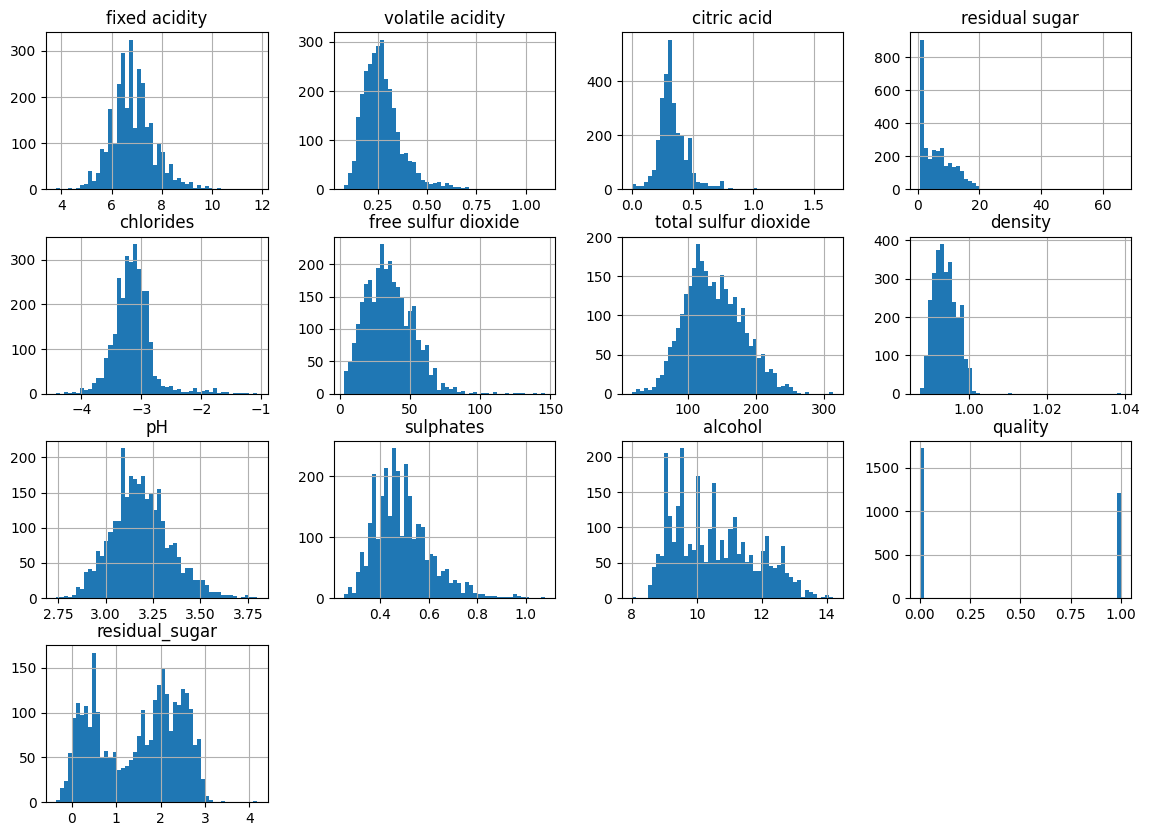

In [177]:
import numpy as np

TRAIN_LOG = TRAIN.assign(
    residual_sugar = lambda x: np.log(x['residual sugar']),
    chlorides = lambda x: np.log(x['chlorides'])
)

TRAIN_LOG.hist(bins = 50, figsize = (14, 10))

로그를 적용함으로써 한쪽으로 치우친 분포가 상당 부분 개선됨을 알 수 있음



정제된 데이터들과 와인의 품지 간의 상관 관계를 확인

In [178]:
TRAIN_CLEAN = TRAIN_LOG
TRAIN_CLEAN.corr(numeric_only=True)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,residual_sugar
fixed acidity,1.000000,-0.002746,0.297196,0.113695,0.059380,-0.045789,0.095765,0.289014,-0.430427,-0.033711,-0.135699,0.771924,0.095330
volatile acidity,-0.002746,1.000000,-0.137112,0.072655,0.026529,-0.113486,0.058242,0.031749,-0.024351,-0.049891,0.083099,-0.032668,0.093558
citric acid,0.297196,-0.137112,1.000000,0.105547,0.122482,0.099128,0.132992,0.162290,-0.169548,0.055903,-0.082352,0.223556,0.072000
residual sugar,0.113695,0.072655,0.105547,1.000000,0.185116,0.307443,0.405521,0.841820,-0.205964,-0.032855,-0.453063,0.101791,0.925633
chlorides,0.059380,0.026529,0.122482,0.185116,1.000000,0.145743,0.290349,0.394888,-0.082010,0.027793,-0.494024,0.037484,0.159165
free sulfur dioxide,-0.045789,-0.113486,0.099128,0.307443,0.145743,1.000000,0.627939,0.295501,-0.007783,0.072696,-0.252982,-0.040578,0.319194
total sulfur dioxide,0.095765,0.058242,0.132992,0.405521,0.290349,0.627939,1.000000,0.525984,0.002506,0.126375,-0.447359,0.068388,0.419519
density,0.289014,0.031749,0.162290,0.841820,0.394888,0.295501,0.525984,1.000000,-0.103637,0.071232,-0.771292,0.227936,0.749713
pH,-0.430427,-0.024351,-0.169548,-0.205964,-0.082010,-0.007783,0.002506,-0.103637,1.000000,0.148386,0.133791,-0.303058,-0.191550
sulphates,-0.033711,-0.049891,0.055903,-0.032855,0.027793,0.072696,0.126375,0.071232,0.148386,1.000000,-0.025601,-0.040634,-0.040208


fixed acidity이 quality와 약 77%의 상관 관계를 가지고 있음: 즉, fixed acidity이 증가할때 마다 quality 또한 굉장히 높은 확률로 증가함



In [179]:
import altair as alt


alt.Chart(
    TRAIN_CLEAN
).encode(
    x=alt.X('fixed acidity'),
    y=alt.X('quality'),
).mark_point(
    fillOpacity=0.2, filled=True
)

alt.Chart(...)

Fixed acidity가 7 정도를 기준으로 quality의 값이 변하는 것을 확인할 수 있음.

In [180]:
TRAIN_FEAT = TRAIN_CLEAN

TRAIN_FEAT.corr(numeric_only=True)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,residual_sugar
fixed acidity,1.000000,-0.002746,0.297196,0.113695,0.059380,-0.045789,0.095765,0.289014,-0.430427,-0.033711,-0.135699,0.771924,0.095330
volatile acidity,-0.002746,1.000000,-0.137112,0.072655,0.026529,-0.113486,0.058242,0.031749,-0.024351,-0.049891,0.083099,-0.032668,0.093558
citric acid,0.297196,-0.137112,1.000000,0.105547,0.122482,0.099128,0.132992,0.162290,-0.169548,0.055903,-0.082352,0.223556,0.072000
residual sugar,0.113695,0.072655,0.105547,1.000000,0.185116,0.307443,0.405521,0.841820,-0.205964,-0.032855,-0.453063,0.101791,0.925633
chlorides,0.059380,0.026529,0.122482,0.185116,1.000000,0.145743,0.290349,0.394888,-0.082010,0.027793,-0.494024,0.037484,0.159165
free sulfur dioxide,-0.045789,-0.113486,0.099128,0.307443,0.145743,1.000000,0.627939,0.295501,-0.007783,0.072696,-0.252982,-0.040578,0.319194
total sulfur dioxide,0.095765,0.058242,0.132992,0.405521,0.290349,0.627939,1.000000,0.525984,0.002506,0.126375,-0.447359,0.068388,0.419519
density,0.289014,0.031749,0.162290,0.841820,0.394888,0.295501,0.525984,1.000000,-0.103637,0.071232,-0.771292,0.227936,0.749713
pH,-0.430427,-0.024351,-0.169548,-0.205964,-0.082010,-0.007783,0.002506,-0.103637,1.000000,0.148386,0.133791,-0.303058,-0.191550
sulphates,-0.033711,-0.049891,0.055903,-0.032855,0.027793,0.072696,0.126375,0.071232,0.148386,1.000000,-0.025601,-0.040634,-0.040208


새롭게 만든 특성값들은 기존에 있던 특성값들과 비교해봤을때 꽤나 좋은 상관관계를 보이며, 예상한 것과 같은 상관 관계를 보임

# Data Splitting
기계 학습 모델의 **일반화 성능을 추정**하기 위해서 전체 데이터를 학습 모델을 훈련하기 위한 **훈련 데이터셋**과 일반화 성능 추정을 위한 **검증 데이터셋**으로 나눔

In [181]:
from sklearn.model_selection import ShuffleSplit

splitter = ShuffleSplit(
    n_splits=1, # Split 생성 개수
    train_size=0.7, # 전체 데이터의 70%를 훈련으로 활용,
    random_state=42
)
I_train, I_eval = next(splitter.split(TRAIN_FEAT))
TRAIN_SET, EVAL_SET = TRAIN_FEAT.iloc[I_train, :], TRAIN_FEAT.iloc[I_eval, :]
print(f'# train: {len(TRAIN_SET)} / # eval: {len(EVAL_SET)}')

# train: 2056 / # eval: 882


# Training & Performance Measure
간단하게 의사 결정 나무 모델로 예측을 수행

Accuracy: 1.0


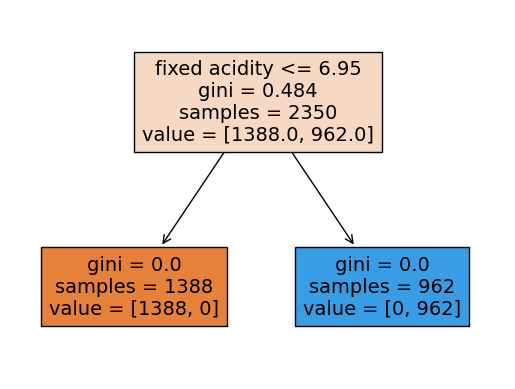

In [182]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# 데이터 불러오기
wine_data = pd.read_csv('train.csv', index_col='id')

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(wine_data.drop('quality', axis=1), wine_data['quality'], test_size=0.2, random_state=42)

# Decision Tree 모델 학습
model = DecisionTreeClassifier(criterion='gini', max_depth=5)
model.fit(X_train, y_train)

# 모델 평가
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# 결과 출력
print('Accuracy:', accuracy)

# 모델 시각화 (옵션)
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plot_tree(model, filled=True, feature_names=X_train.columns)
plt.show()


# Prediction on the Test Set

학습 모델 훈련을 끝냈으니 테스트셋에 대한 예측 결과를 확인할 차례

In [183]:
import pandas as pd

TEST = pd.read_csv('./test.csv', index_col='id')
TEST.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
id,,,,,,,,,,,
4809.0,6.0,0.26,0.24,1.3,0.053,66.0,150.0,0.99240,3.21,0.62,10.4
3188.0,7.0,0.17,0.36,6.4,0.055,42.0,123.0,0.99318,3.11,0.50,11.0
4722.0,6.0,0.25,0.28,7.7,0.053,37.0,132.0,0.99489,3.06,0.50,9.4
3557.0,8.1,0.20,0.28,0.9,0.023,49.0,87.0,0.99062,2.92,0.36,11.1
149.0,6.9,0.25,0.30,4.1,0.054,23.0,116.0,0.99400,2.99,0.38,9.4


사용했던 데이터와는 다르게, 예측해야하는 출력값인 quality가 없음을 확인할 수 있음. 일단, 테스트셋이 제대로 수집되어 있는지를 확인

In [184]:
for c in TEST.columns:
    print(f'{c}: {len(TEST[c].loc[TEST[c].isnull()])}')

fixed acidity: 0
volatile acidity: 0
citric acid: 0
residual sugar: 0
chlorides: 0
free sulfur dioxide: 0
total sulfur dioxide: 0
density: 0
pH: 0
sulphates: 0
alcohol: 0




그 이외에는 지금까지 했던 처리 과정을 테스트셋에 대해 반복함
* 분포가 치우친 데이터에 대한 Log 적용
* 새로운 특성값 생성
* 범주형 데이터에 대한 인코딩
* 수치형 데이터에 대한 표준화

In [185]:
import numpy as np
import pandas as pd


# Log 적용
TEST_LOG = TEST.assign(
    # residual_sugar = lambda x: np.log(x['residual sugar']),
    chlorides = lambda x: np.log(x['chlorides'])
)

TEST_PRC = TEST_LOG

y_test_pred = model.predict(TEST_PRC)
y_test_pred

array([0., 1., 0., ..., 1., 0., 0.])

# Submission

* 제출물
  * 테스트셋 예측 결과를 Kaggle에 업로드
  * Jupyter Notebook 파일(.ipynb)을 이루리에 업로드

* 제출 마감
  * 24.03.20 23:59

* 평가 기준
  * 제출마감 기한 내 두 제출물을 제출 시 4%
  * 두 제출물 중 하나라도 지연 또는 미제출 시 0%


## Kaggle에 예측 결과 업로드

제출 형식은 id 값과 그에 상응하는 출력값(Competition - [Data](https://www.kaggle.com/competitions/2024-knu-ml-ind-asmt1/data)의 **sample_submission.csv** 참조)이므로 다음과 같이 데이터를 만듦

In [186]:
SUBMIT = pd.DataFrame({
    'id': TEST_PRC.index,
    'quality': y_test_pred
})
SUBMIT

,id,quality
0,4809.0,0.0
1,3188.0,1.0
2,4722.0,0.0
3,3557.0,1.0
4,149.0,0.0
...,...,...
1955,4527.0,0.0
1956,333.0,0.0
1957,3849.0,1.0
1958,458.0,0.0


만든 Dataframe을 파일 시스템에 저장

In [187]:
SUBMIT.to_csv('./submission.csv', index=False)

그 다음 Kaggle API를 통해 이 파일을 업로드 하면 됨

In [188]:
!kaggle competitions submit --file submission.csv --message "This is first submission" 2024-knu-ml-ind-asmt2

100% 20.6k/20.6k [00:01<00:00, 13.2kB/s]
Successfully submitted to Individual Assignment #2

단, 공개되는 리더보드의 결과는 전체 테스트셋의 일부 데이터에 대해서면 측정한 것. 최종 결과는 Competition 종료 후에 공개됨. 이는 다음과 같은 Cheating을 방지하기 위함:
* 테스트셋의 참인 출력을 모르더라도, 성능치의 변화를 확인해서 손으로 출력값을 조정하면서 높은 성능을 만들어낼 수 있음
* 이를 방지하기 위해, (1) 일부 테스트 데이터에 대한 성능만을 보여주고, 나머지에 대해서는 숨기며, (2) 하루에 제출할 수 있는 횟수를 제한함

이 실습에서는 다음과 같은 설정이 존재:
* 40%의 테스트셋의 성능 결과를 Competition 리더보드에 공개; Competition이 종료된 후 최종 성능 결과를 공개
* 일일 제출 횟수는 5번

